In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from collections import Counter

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress, skew
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, confusion_matrix, silhouette_score, silhouette_samples

In [6]:
def dump_pickle(file, filename):
    outfile = open(filename, 'wb')
    pickle.dump(file, outfile)
    outfile.close()

def load_pickle(filename):
    infile = open(filename, 'rb')
    file = pickle.load(infile)
    infile.close()
    return file

In [7]:
sns.set()

## Data Prep

Load models

In [8]:
nba_clustering_models = load_pickle('nba_clustering_models')
nba_clustering_models.keys()

dict_keys(['pre_pca_pipe', 'pca', 'pre_cluster_scaler', 'cluster_dict'])

In [9]:
cluster_dict = nba_clustering_models['cluster_dict']

Read data

In [10]:
df = pd.read_csv('nba_cleaned.csv')
df.shape

(1420, 116)

In [11]:
labels = df['player_cluster'].values

In [12]:
poss_weights_cols = ['Spot Up_Poss%', 'P&R Ball Handler_Poss%', 
                     'Hand Off_Poss%', 'Off Screen_Poss%',
                     'Cut_Poss%', 'Offensive Rebounds (put backs)_Poss%',
                     'P&R Roll Man_Poss%', 'Isolation_Poss%', 
                     'Post-Up_Poss%']

In [13]:
X = df[poss_weights_cols].copy()

In [14]:
X_transformed = X.copy()
queues = ['pre_pca_pipe', 'pca', 'pre_cluster_scaler']
for step in queues:
    X_transformed = nba_clustering_models[step].transform(X_transformed)

In [15]:
tsne = TSNE(perplexity=30, random_state=0)
X_tsne = tsne.fit_transform(X_transformed)

## Function

In [16]:
def plot_players(lookup_idx, labels=labels, X_tsne=X_tsne, df=df, cluster_dict=cluster_dict):
    n_clusters = len(set(labels))
    for i in range(n_clusters):
        cluster_index = [j for j in range(len(labels)) if labels[j] == i]
        plt.scatter(X_tsne[cluster_index, 0], X_tsne[cluster_index, 1], 
                    label=f'Cluster {i}: {cluster_dict[i]}', alpha=0.3)
    plt.legend()
    plt.title('TSNE Visualization (Spectral Clustering based on 6 PCA features)')
    for idx in lookup_idx:
        player_coord = X_tsne[idx]
        plt.scatter(player_coord[0], player_coord[1], marker='x', color='black')
        plt.annotate(f"{df.loc[idx]['Player']} {df.loc[idx]['Season']} {df.loc[idx]['Team']}", 
                     player_coord, alpha=0.6)

## Case Study

### 2022 Celtics Playoff Run

Celtics

In [17]:
lookup_players = ['Jayson Tatum', 'Jaylen Brown', 'Marcus Smart',
                  'Al Horford', 'Robert Williams III']
lookup_idx = df[df['Player'].isin(lookup_players)].index

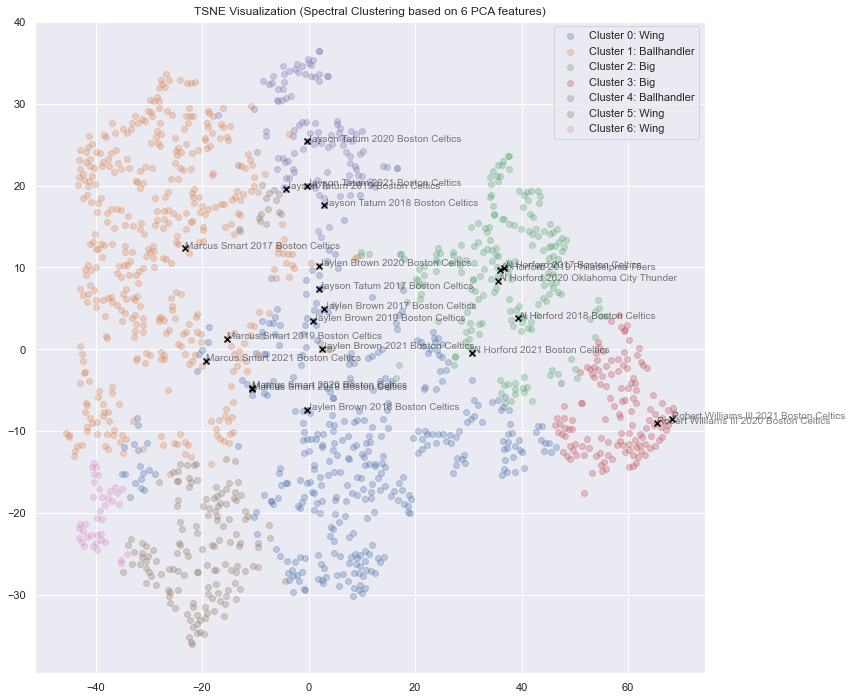

In [19]:
figsize(12, 12)
plot_players(lookup_idx)

Warriors

In [20]:
lookup_players = ['Stephen Curry', 'Klay Thompson', 'Draymond Green',
                  'Andrew Wiggins', 'AndrewWiggins', 'Jordan Poole']
lookup_idx = df[df['Player'].isin(lookup_players)].index

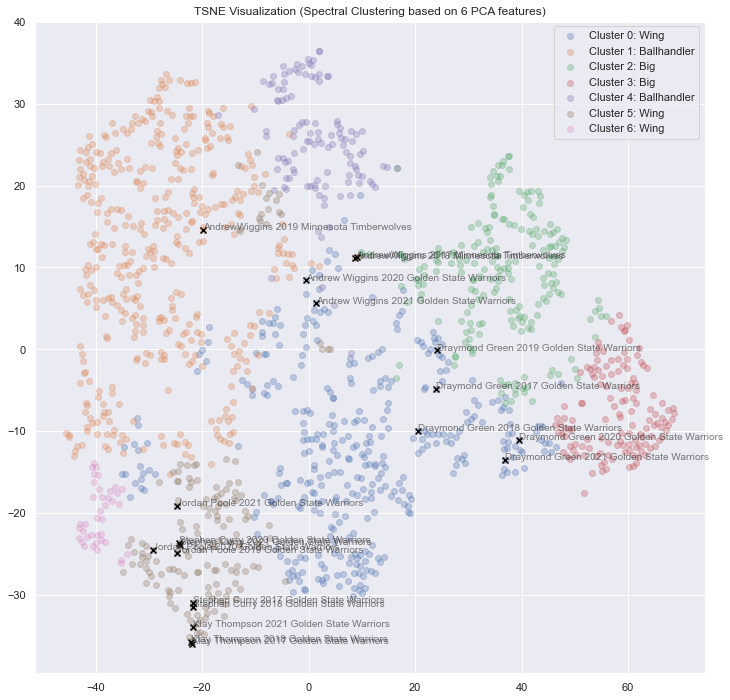

In [21]:
figsize(12, 12)
plot_players(lookup_idx)

Celtics Playoff Opponents

In [22]:
lookup_players = ['Kyrie Irving', 'Kevin Durant',
                  'Giannis Antetokoumpo', 'Jrue Holiday',
                  'Jimmy Butler', 'Bam Adebayo']
lookup_idx = df[df['Player'].isin(lookup_players)].index

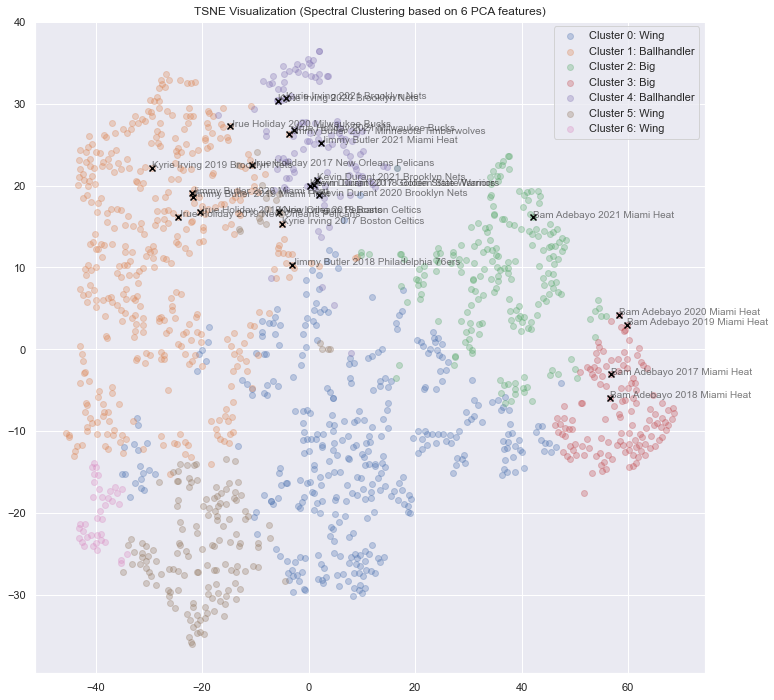

In [23]:
figsize(12, 12)
plot_players(lookup_idx)

### Cluster 4: Big Man Fall into 'Ballhandling Category'

In [24]:
df[df['player_cluster'] == 4].sort_values('P&R Ball Handler_Poss%')\
[['Player', 'Season', 'P&R Ball Handler_Poss%', 'P&R Roll Man_Poss%']].head(20)

,Player,Season,P&R Ball Handler_Poss%,P&R Roll Man_Poss%
1354,Karl-Anthony Towns,2021,0.017910,0.152239
194,Michael Beasley,2017,0.030127,0.147161
529,Julius Randle,2018,0.036554,0.087903
205,Rondae Hollis-Jefferson,2017,0.042177,0.129252
759,Julius Randle,2019,0.052028,0.112875
670,Eric Paschall,2019,0.053492,0.056464
447,Paul Millsap,2018,0.055556,0.052778
114,Danilo Gallinari,2017,0.058594,0.082031
1318,Julius Randle,2021,0.063401,0.121758
1294,Aaron Gordon,2021,0.063750,0.063750


In [29]:
lookup_idx = df[df['player_cluster'] == 4].sort_values('P&R Ball Handler_Poss%')\
             [['Player', 'Season', 'P&R Ball Handler_Poss%', 'P&R Roll Man_Poss%']]\
                                          .head(20).index

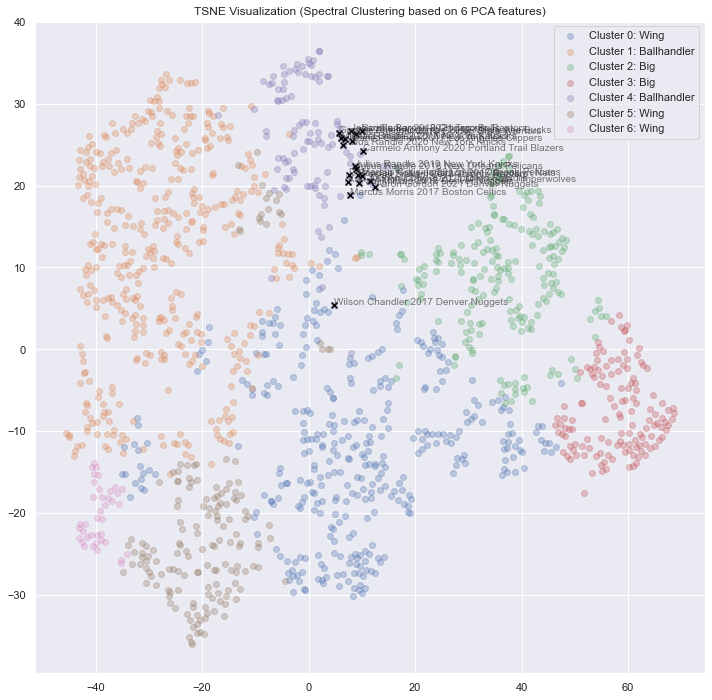

In [30]:
figsize(12, 12)
plot_players(lookup_idx)

Karl-Anthony Towns

In [27]:
for col in df.columns:
    if 'Poss%' in col:
        num = df[(df['player_cluster'] == 4) & 
                 (df['Player'] == 'Karl-Anthony Towns')].loc[1354][col]
        print(col, f'{num:.1%}')

Spot Up_Poss% 24.3%
Transition_Poss% 10.8%
P&R Ball Handler_Poss% 1.8%
Offensive Rebounds (put backs)_Poss% 10.1%
Cut_Poss% 6.7%
Hand Off_Poss% 2.8%
Isolation_Poss% 15.1%
Off Screen_Poss% 6.2%
P&R Roll Man_Poss% 15.2%
Post-Up_Poss% 17.8%
Miscellaneous_Poss% 6.9%


DeMarcus Cousins

In [28]:
for col in df.columns:
    if 'Poss%' in col:
        num = df[(df['player_cluster'] == 4) & 
                 (df['Player'] == 'DeMarcus Cousins')].loc[241][col]
        print(col, f'{num:.1%}')

Spot Up_Poss% 25.5%
Transition_Poss% 13.4%
P&R Ball Handler_Poss% 7.0%
Offensive Rebounds (put backs)_Poss% 8.0%
Cut_Poss% 5.3%
Hand Off_Poss% 1.9%
Isolation_Poss% 16.1%
Off Screen_Poss% 4.5%
P&R Roll Man_Poss% 10.7%
Post-Up_Poss% 21.1%
Miscellaneous_Poss% 8.0%


In [31]:
lookup_players = ['Karl-Anthony Towns', 'DeMarcus Cousins', 'Zion Williamson']
lookup_idx = df[df['Player'].isin(lookup_players)].index

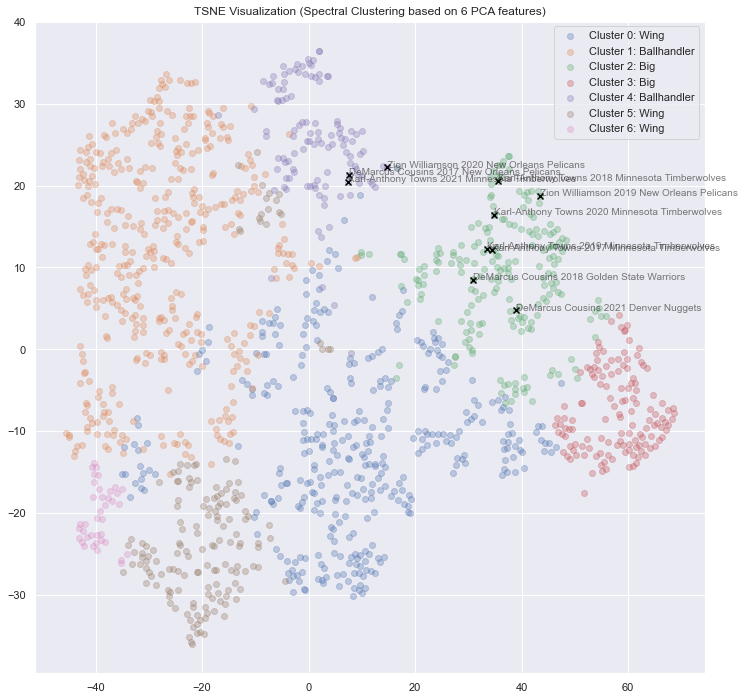

In [32]:
figsize(12, 12)
plot_players(lookup_idx)

### Three-Type Players / Players Jump b/w Ballhandler and Big

In [33]:
temp = df.groupby('Player')['player_cluster'].apply(list).reset_index()
temp['player_cluster_adj'] = temp['player_cluster'].apply(lambda x: [cluster_dict[s] 
                                                                     for s in x])\
                                                   .apply(set)
temp['player_cluster'] = temp['player_cluster'].apply(set)
temp['n_cluster'] = temp['player_cluster_adj'].apply(len)
temp[temp['n_cluster'] == 3]

,Player,player_cluster,player_cluster_adj,n_cluster
0,Aaron Gordon,"{0, 2, 4}","{Ballhandler, Big, Wing}",3
47,Bruce Brown,"{0, 1, 3}","{Ballhandler, Big, Wing}",3
184,Harrison Barnes,"{0, 2, 4}","{Ballhandler, Big, Wing}",3
407,Paul Millsap,"{0, 2, 4}","{Ballhandler, Big, Wing}",3
427,Rondae Hollis-Jefferson,"{0, 3, 4}","{Ballhandler, Big, Wing}",3
472,Tobias Harris,"{0, 2, 4}","{Ballhandler, Big, Wing}",3


In [37]:
temp[(temp['n_cluster'] == 2) & (temp['player_cluster_adj'] == set(['Ballhandler', 'Big']))]

,Player,player_cluster,player_cluster_adj,n_cluster
34,Ben Simmons,"{1, 2, 4}","{Ballhandler, Big}",2
60,Carmelo Anthony,"{2, 4}","{Ballhandler, Big}",2
88,Danilo Gallinari,"{2, 4}","{Ballhandler, Big}",2
107,DeMarcus Cousins,"{2, 4}","{Ballhandler, Big}",2
270,Julius Randle,"{2, 4}","{Ballhandler, Big}",2
275,Karl-Anthony Towns,"{2, 4}","{Ballhandler, Big}",2
336,Marcus Morris,"{2, 4}","{Ballhandler, Big}",2
337,Marcus Morris Sr.,"{2, 4}","{Ballhandler, Big}",2
515,Zion Williamson,"{2, 4}","{Ballhandler, Big}",2


In [46]:
lookup_players = ['Tobias Harris', 'Aaron Gordon']
lookup_idx = df[df['Player'].isin(lookup_players)].index

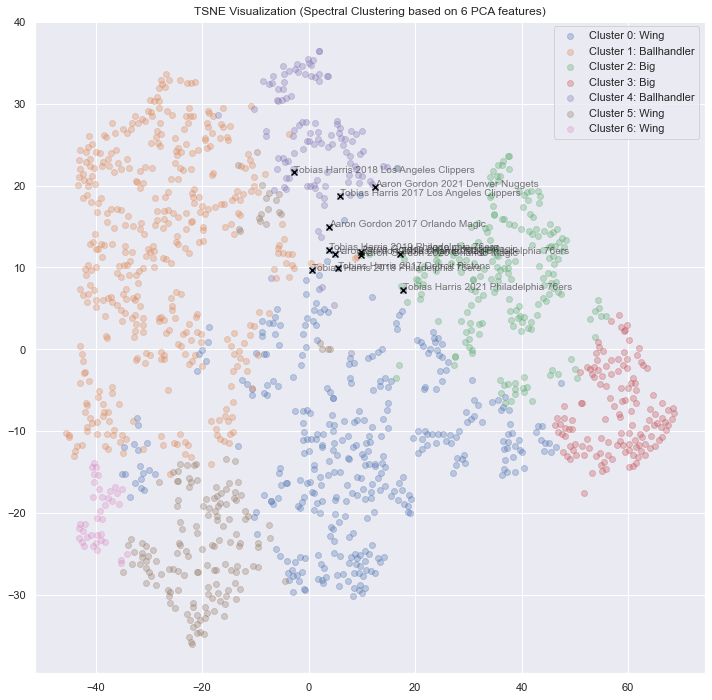

In [47]:
figsize(12, 12)
plot_players(lookup_idx)

In [58]:
lookup_players = ['Julius Randle', 'Carmelo Anthony', 
                  'Marcus Morris Sr.', 'Marcus Morris']
lookup_idx = df[df['Player'].isin(lookup_players)].index

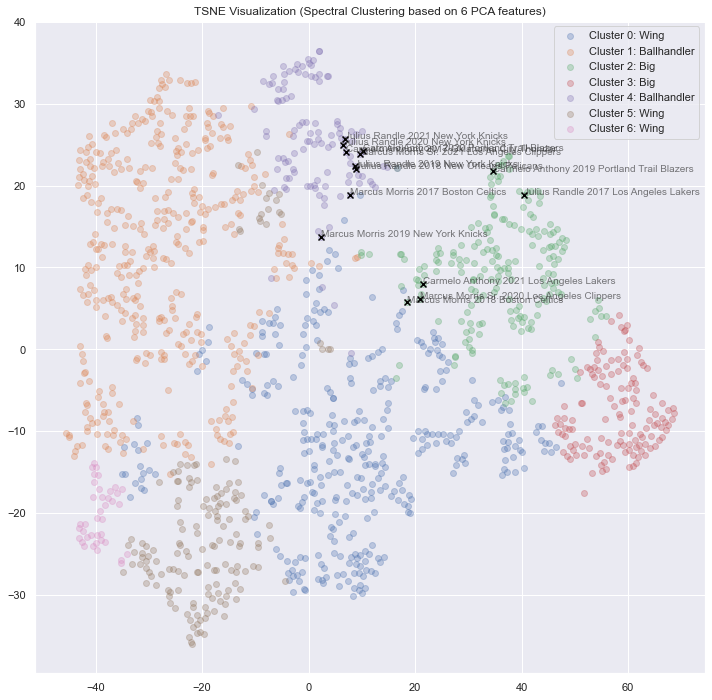

In [59]:
figsize(12, 12)
plot_players(lookup_idx)

In [40]:
lookup_players = ['Bruce Brown', 'Ben Simmons', 'Rondae Hollis-Jefferson']
lookup_idx = df[df['Player'].isin(lookup_players)].index

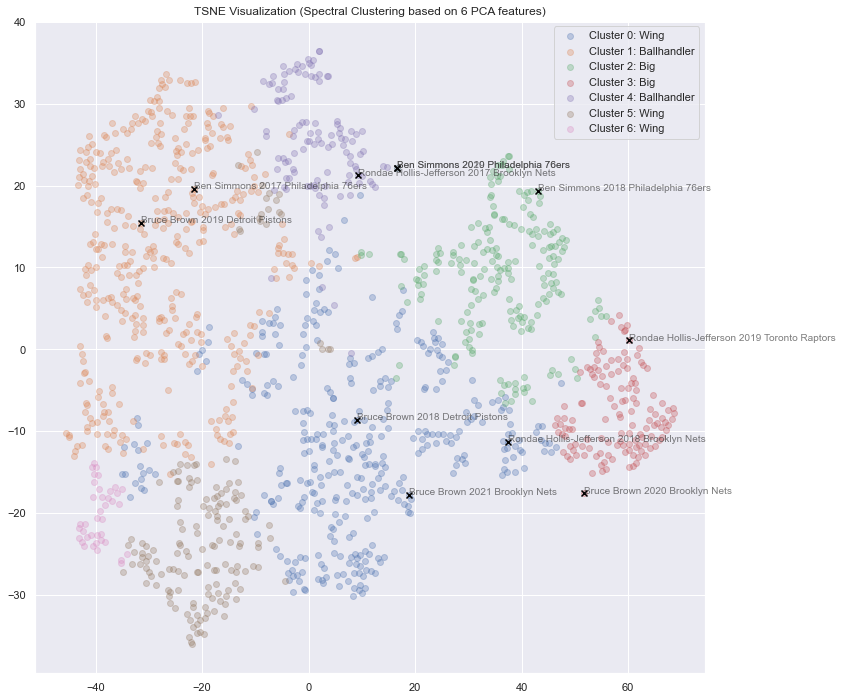

In [41]:
figsize(12, 12)
plot_players(lookup_idx)

In [50]:
lookup_players = ['Eric Paschall', 'Harrison Barnes', 
                  'Danilo Gallinari', 'Paul Millsap']
lookup_idx = df[df['Player'].isin(lookup_players)].index

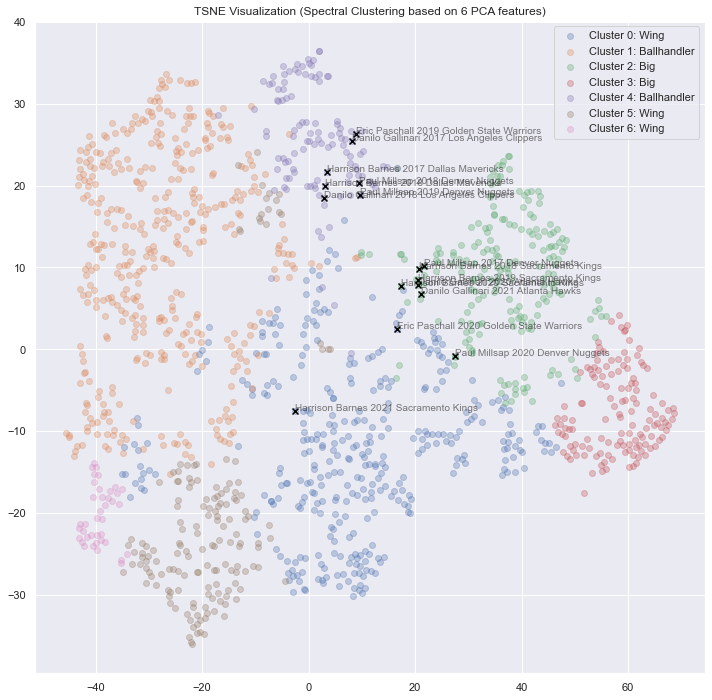

In [51]:
figsize(12, 12)
plot_players(lookup_idx)